<a href="https://colab.research.google.com/github/SHayashida/Amanogawa/blob/main/Amanogawa_band.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 天の川バンド構造の統計解析

このノートブックは、スマートフォンのカメラで撮影された天の川画像から、星の分布パターンと銀河バンド構造の統計的特性を解析するサンプルコードです。

## 分析内容
1. **星検出**: LoG (Laplacian of Gaussian) ブロブ検出による星の自動抽出
2. **空間統計**: 最近傍距離分布、フラクタル次元、2点相関関数による空間パターン解析
3. **バンド解析**: PCA主成分分析による天の川バンドの方向・幅測定
4. **等級解析**: アパーチャフォトメトリによる星の明るさ分布調査

## データ
- **対象画像**: `IMG_5991.jpg` (data/raw/)
- **Astrometry解析結果**: https://nova.astrometry.net/user_images/13461052#annotated
- **出力先**: `outputs/` ディレクトリ

## Zenodo公開用
このコードは研究の再現性確保のため、完全に実行可能な状態でZenodoに公開されています。

=== 天の川バンド分析サンプル ===
分析対象画像: IMG_5991.jpg
画像サイズ: 3024 × 4032 ピクセル

--- 星の検出処理 ---
検出パラメータ: max_sigma=6, num_sigma=12, threshold=0.05
検出された星の数: 13733
座標データ保存先: /Users/linda/Documents/Amanogawa/outputs/IMG_5991_star_coords.csv
平均星半径: 1.69 ± 0.48 ピクセル
検出パラメータ: max_sigma=6, num_sigma=12, threshold=0.05
検出された星の数: 13733
座標データ保存先: /Users/linda/Documents/Amanogawa/outputs/IMG_5991_star_coords.csv
平均星半径: 1.69 ± 0.48 ピクセル
Star distribution map saved: /Users/linda/Documents/Amanogawa/outputs/figures/star_distribution_map.png
Star distribution map saved: /Users/linda/Documents/Amanogawa/outputs/figures/star_distribution_map.png


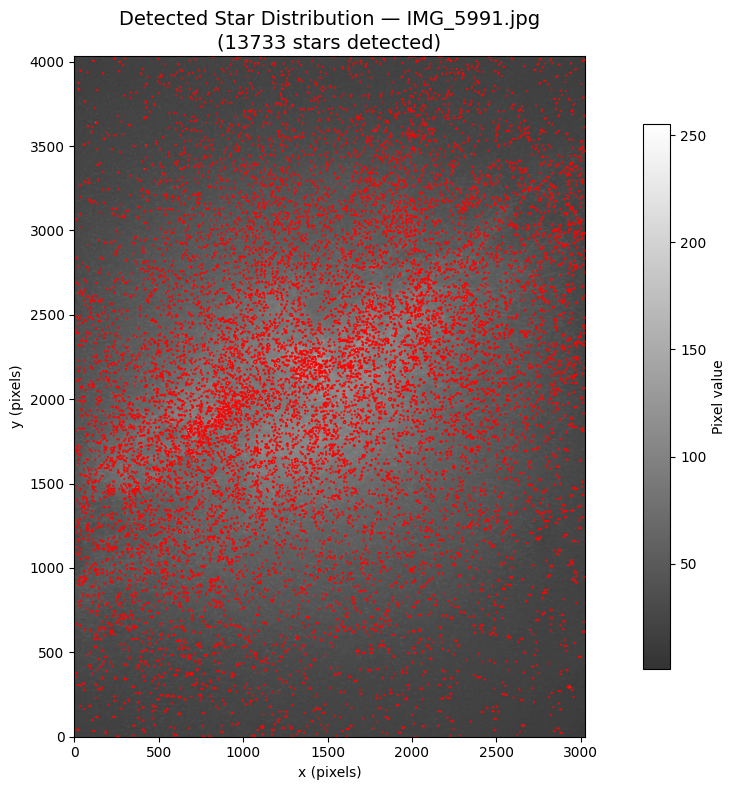

Star density map saved: /Users/linda/Documents/Amanogawa/outputs/figures/star_density_map.png


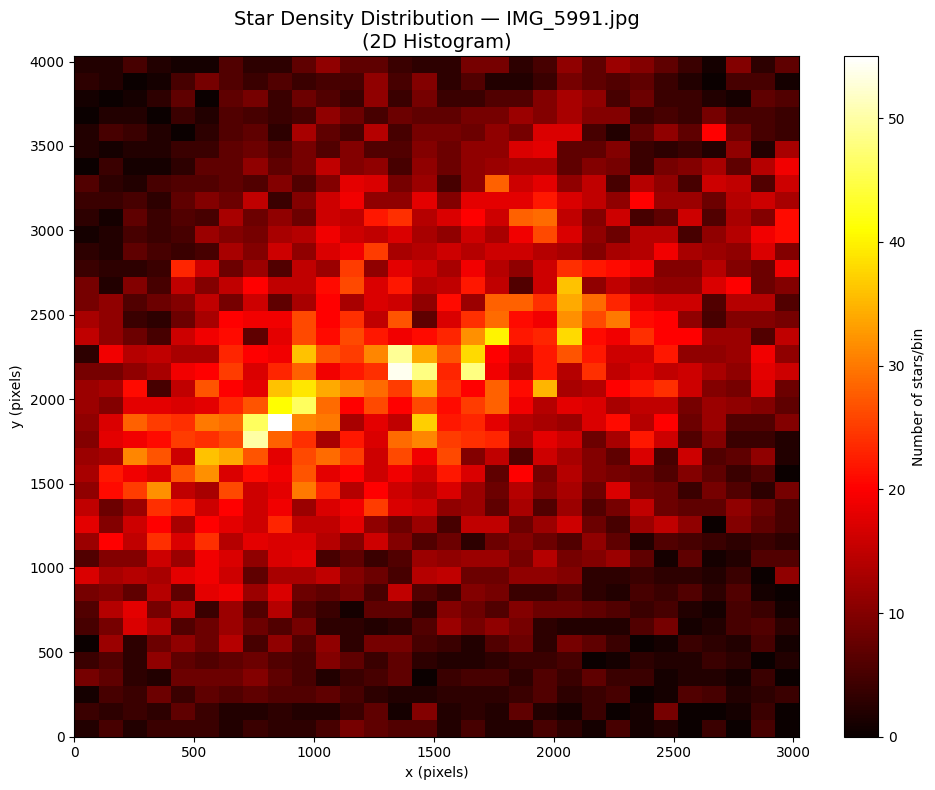


--- Analysis Results Summary ---


,image,width_px,height_px,num_stars_detected,mean_radius_px,std_radius_px
0,IMG_5991.jpg,3024,4032,13733,1.686204,0.482172


Analysis summary saved: /Users/linda/Documents/Amanogawa/outputs/results/detection_summary.json


In [11]:
# Milky Way Band Analysis - Sample Data Processing
# IMG_5991.jpgの天の川バンド構造を分析するサンプルコード

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
import pandas as pd
from pathlib import Path

# 実際のファイルパスを設定
IMAGE_PATH = "/Users/linda/Documents/Amanogawa/data/raw/IMG_5991.jpg"
OUTPUT_DIR = Path("/Users/linda/Documents/Amanogawa/outputs")

# 出力ディレクトリを確認・作成
OUTPUT_DIR.mkdir(exist_ok=True)

print("=== 天の川バンド分析サンプル ===")
print(f"分析対象画像: {Path(IMAGE_PATH).name}")

# 画像の読み込みと基本情報表示
img = Image.open(IMAGE_PATH).convert("L")
data = np.array(img)
H, W = data.shape
print(f"画像サイズ: {W} × {H} ピクセル")

# 星の検出（LoG blob detection）
print("\n--- 星の検出処理 ---")
blobs = blob_log(data, max_sigma=6, num_sigma=12, threshold=0.05)
print(f"検出パラメータ: max_sigma=6, num_sigma=12, threshold=0.05")

if len(blobs) > 0:
    xs = blobs[:,1]  # x座標
    ys = blobs[:,0]  # y座標 
    rs = blobs[:,2]  # 半径
    
    # 座標データの保存
    df = pd.DataFrame({"x": xs, "y": ys, "radius": rs})
    csv_path = OUTPUT_DIR / f"{Path(IMAGE_PATH).stem}_star_coords.csv"
    df.to_csv(csv_path, index=False)
    print(f"検出された星の数: {len(df)}")
    print(f"座標データ保存先: {csv_path}")
    
    # 基本統計
    summary = {
        "image": Path(IMAGE_PATH).name,
        "width_px": W,
        "height_px": H,
        "num_stars_detected": len(df),
        "mean_radius_px": float(df["radius"].mean()),
        "std_radius_px": float(df["radius"].std())
    }
    
    print(f"平均星半径: {summary['mean_radius_px']:.2f} ± {summary['std_radius_px']:.2f} ピクセル")
    
    # 1) 星の分布マップ（散布図）
    plt.figure(figsize=(12,8))
    plt.imshow(data, cmap="gray", origin="lower", alpha=0.8)
    
    # 検出された星を円でマーク
    for x, y, r in zip(xs, ys, rs):
        circle = plt.Circle((x, y), r*1.5, fill=False, color='red', linewidth=1)
        plt.gca().add_patch(circle)
    
    plt.title(f"Detected Star Distribution — {Path(IMAGE_PATH).name}\n({len(df)} stars detected)", fontsize=14)
    plt.xlabel("x (pixels)")
    plt.ylabel("y (pixels)")
    plt.colorbar(label="Pixel value", shrink=0.8)
    plt.tight_layout()
    
    # 図の保存
    fig_path = OUTPUT_DIR / "figures" / "star_distribution_map.png"
    fig_path.parent.mkdir(exist_ok=True)
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Star distribution map saved: {fig_path}")
    plt.show()
    
    # 2) 星密度の2Dヒストグラム
    bins_x = max(20, W//100)  # 解像度調整
    bins_y = max(20, H//100)
    
    plt.figure(figsize=(10,8))
    plt.hist2d(xs, ys, bins=[bins_x, bins_y], cmap='hot')
    plt.title(f"Star Density Distribution — {Path(IMAGE_PATH).name}\n(2D Histogram)", fontsize=14)
    plt.xlabel("x (pixels)")
    plt.ylabel("y (pixels)")
    plt.colorbar(label="Number of stars/bin")
    plt.tight_layout()
    
    # 密度マップの保存
    density_path = OUTPUT_DIR / "figures" / "star_density_map.png"
    plt.savefig(density_path, dpi=150, bbox_inches='tight')
    print(f"Star density map saved: {density_path}")
    plt.show()
    
    # サマリー情報の表示と保存
    summary_df = pd.DataFrame([summary])
    print("\n--- Analysis Results Summary ---")
    display(summary_df)
    
    # サマリーの保存
    summary_path = OUTPUT_DIR / "results" / "detection_summary.json"
    summary_path.parent.mkdir(exist_ok=True)
    import json
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)
    print(f"Analysis summary saved: {summary_path}")
    
else:
    print("警告: 星が検出されませんでした。閾值を調整してください。")

In [12]:
# Advanced Analysis Functions and Setup
# 高度な統計解析とバンド幾何学解析のための関数定義

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.feature import blob_log
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
import json, math, os, random

# 再現可能性のためのシード設定
np.random.seed(42)
random.seed(42)

# ファイルパス設定（実際のワークスペースパス）
BASE_DIR = Path("/Users/linda/Documents/Amanogawa")
IMAGE_PATH = BASE_DIR / "data/raw/IMG_5991.jpg"
OUTPUT_DIR = BASE_DIR / "outputs"
COORDS_CSV = OUTPUT_DIR / "IMG_5991_star_coords.csv"

print("=== 高度解析用関数の定義 ===")

# --- I/O & 基本処理関数 ---
def load_image_gray(path):
    """グレースケール画像を読み込み、numpy配列として返す"""
    img = Image.open(path).convert("L")
    data = np.array(img)
    H, W = data.shape
    return data, (W, H)

def detect_stars_log(data, max_sigma=6, num_sigma=12, threshold=0.05):
    """LoG (Laplacian of Gaussian) を使った星検出"""
    blobs = blob_log(data, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    if len(blobs) == 0:
        return pd.DataFrame(columns=["x","y","r"])
    return pd.DataFrame({"x": blobs[:,1], "y": blobs[:,0], "r": blobs[:,2]})

def load_or_detect(coords_csv, image_path, detect_threshold=0.05):
    """既存の座標CSVを読み込み、無ければ星検出を実行"""
    data, (W,H) = load_image_gray(image_path)
    p = Path(coords_csv)
    if p.exists():
        df = pd.read_csv(p)
        print(f"[INFO] 座標データを読み込み: {p}, N={len(df)}")
    else:
        df = detect_stars_log(data, threshold=detect_threshold)
        p.parent.mkdir(exist_ok=True)
        df.to_csv(coords_csv, index=False)
        print(f"[INFO] LoGで星検出を実行: N={len(df)}, 保存先: {coords_csv}")
    
    # 画像範囲内の点のみを保持
    m = (df["x"].between(0, W-1)) & (df["y"].between(0, H-1))
    df = df[m].reset_index(drop=True)
    return data, (W,H), df

# --- 幾何・統計解析関数 ---
def nearest_neighbor_dist(points):
    """最近傍距離の計算"""
    tree = cKDTree(points)
    dists, _ = tree.query(points, k=2)
    return dists[:,1]  # 自分自身を除く最近傍距離

def two_point_correlation(points, W, H, r_bins, maxN=4000):
    """2点相関関数 ξ(r) ≈ DD/RR - 1 の計算（Poisson参照モデル使用）"""
    P = points
    if len(P) > maxN:
        idx = np.random.choice(len(P), maxN, replace=False)
        P = P[idx]
    
    # データ-データ相関 (DD)
    tree = cKDTree(P)
    DD = np.zeros(len(r_bins)-1)
    for i in range(len(P)):
        idxs = tree.query_ball_point(P[i], r_bins[-1])
        d = np.linalg.norm(P[idxs]-P[i], axis=1)
        d = d[d>0]  # 自分自身を除く
        h,_ = np.histogram(d, bins=r_bins)
        DD += h
    DD /= 2.0  # 重複カウントを修正
    
    # ランダム-ランダム参照 (RR) - Poissonモデル
    R = np.column_stack([np.random.uniform(0, W, len(P)),
                         np.random.uniform(0, H, len(P))])
    treeR = cKDTree(R)
    RR = np.zeros(len(r_bins)-1)
    for i in range(len(R)):
        idxs = treeR.query_ball_point(R[i], r_bins[-1])
        d = np.linalg.norm(R[idxs]-R[i], axis=1)
        d = d[d>0]
        h,_ = np.histogram(d, bins=r_bins)
        RR += h
    RR /= 2.0
    
    # 相関関数の計算
    xi = DD/(RR+1e-9) - 1.0
    r_centers = 0.5*(r_bins[1:]+r_bins[:-1])
    return r_centers, xi

def boxcount_fractal_dim(points, W, H, exp_from=-1.0, exp_to=-2.2, steps=10):
    """ボックスカウント法によるフラクタル次元の推定"""
    X = np.column_stack([points[:,0]/W, points[:,1]/H])  # 正規化座標
    eps_list = np.logspace(exp_from, exp_to, steps)
    Ns = []
    
    for eps in eps_list:
        bins = int(np.ceil(1/eps))
        grid = np.floor(X*bins).astype(int)
        grid[grid==bins] = bins-1  # 境界値の修正
        unique_boxes = len(np.unique(grid, axis=0))
        Ns.append(unique_boxes)
    
    eps = np.array(eps_list)
    Ns = np.array(Ns)
    
    # フラクタル次元 = log(N) / log(1/eps) の傾き
    D = np.polyfit(np.log(1/eps), np.log(Ns), 1)[0]
    return D, eps, Ns

def pca_principal_axis(points, W, H, bins_x=60):
    """PCAによる主軸方向の推定（天の川バンドの方向検出用）"""
    bins_y = int(bins_x * H / W)
    
    # 2Dヒストグラムを作成
    hist, xedges, yedges = np.histogram2d(points[:,0], points[:,1],
                                          bins=[bins_x, bins_y],
                                          range=[[0,W],[0,H]])
    
    # ビン中心座標
    xc = 0.5*(xedges[1:]+xedges[:-1])
    yc = 0.5*(yedges[1:]+yedges[:-1])
    XX, YY = np.meshgrid(xc, yc, indexing='xy')
    weights = hist.T
    
    # 重心計算
    xw = np.average(XX, weights=weights)
    yw = np.average(YY, weights=weights)
    
    # 共分散行列
    dx = XX-xw
    dy = YY-yw
    C = np.array([[np.average(dx*dx, weights=weights), np.average(dx*dy, weights=weights)],
                  [np.average(dx*dy, weights=weights), np.average(dy*dy, weights=weights)]])
    
    # 固有値・固有ベクトル
    vals, vecs = np.linalg.eig(C)
    v = vecs[:, np.argmax(vals)]  # 最大固有値に対応する固有ベクトル
    
    # 角度（度）
    ang = math.degrees(math.atan2(v[1], v[0]))
    return ang, (xw, yw)

def rotate_points(points, angle_deg, center):
    """点群を指定角度で回転"""
    th = math.radians(angle_deg)
    R = np.array([[math.cos(th), -math.sin(th)],
                  [math.sin(th), math.cos(th)]])
    return (points-center)@R.T + center

# --- フォトメトリ関数 ---
def simple_aperture_mags_with_indices(img, points, r=2, r_in=6, r_out=10, max_samples=15000):
    """簡易アパーチャフォトメトリによる等級測定"""
    H, W = img.shape
    
    # サンプリング
    if len(points) > max_samples:
        idx_sample = np.random.choice(len(points), max_samples, replace=False)
        pts_sample = points[idx_sample]
    else:
        idx_sample = np.arange(len(points))
        pts_sample = points
    
    mags = []
    valid_idx = []
    
    for i,(x,y) in enumerate(pts_sample):
        x = int(round(x))
        y = int(round(y))
        
        # アパーチャ領域
        x0=max(0,x-r); x1=min(W,x+r+1)
        y0=max(0,y-r); y1=min(H,y+r+1)
        stamp = img[y0:y1, x0:x1]
        signal = np.sum(stamp)
        
        # 背景測定（アニュラス領域）
        yin0=max(0,y-r_out); yin1=min(H,y+r_out+1)
        xin0=max(0,x-r_out); xin1=min(W,x+r_out+1)
        ann = img[yin0:yin1, xin0:xin1].astype(float)
        
        # 内側円を除外
        yy,xx = np.ogrid[yin0:yin1, xin0:xin1]
        ann = ann[~(((xx-x)**2+(yy-y)**2) <= r_in**2)]
        
        # 背景レベル
        bkg = np.median(ann) if ann.size>0 else 0.0
        flux = signal - bkg*stamp.size
        
        if flux > 0:
            mag = -2.5*np.log10(flux)
            mags.append(mag)
            valid_idx.append(idx_sample[i])
    
    return np.array(mags), np.array(valid_idx)

print(f"分析対象画像: {IMAGE_PATH}")
print(f"出力ディレクトリ: {OUTPUT_DIR}")
print("関数定義完了")

=== 高度解析用関数の定義 ===
分析対象画像: /Users/linda/Documents/Amanogawa/data/raw/IMG_5991.jpg
出力ディレクトリ: /Users/linda/Documents/Amanogawa/outputs
関数定義完了


=== 統合分析パイプラインの開始 ===
[INFO] 座標データを読み込み: /Users/linda/Documents/Amanogawa/outputs/IMG_5991_star_coords.csv, N=13733
画像サイズ: 3024 × 4032 ピクセル
検出された星の数: 13733

--- 基本統計解析 ---
最近傍距離: 平均 12.56 ± 8.52 px
フラクタル次元: D ≈ 1.672
平均相関: ξ̄ = 0.4572

--- 可視化の生成 ---
平均相関: ξ̄ = 0.4572

--- 可視化の生成 ---


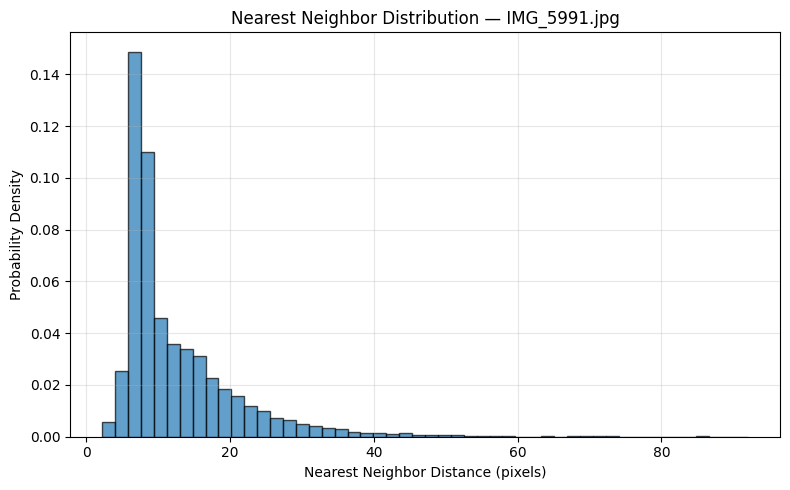

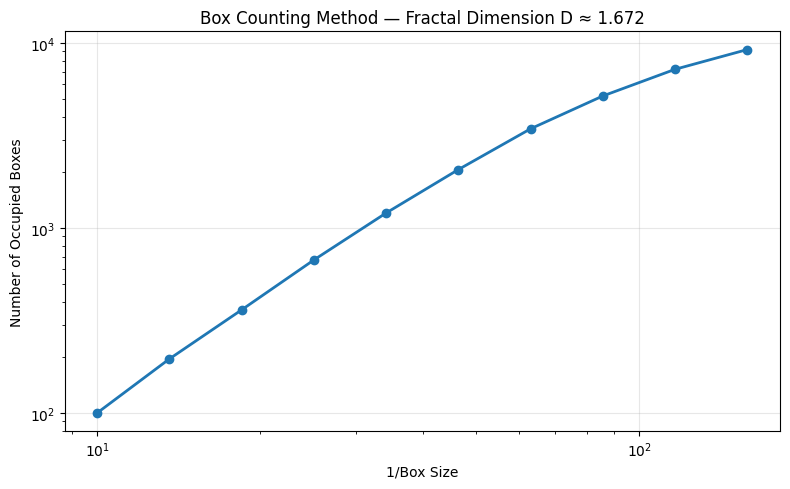

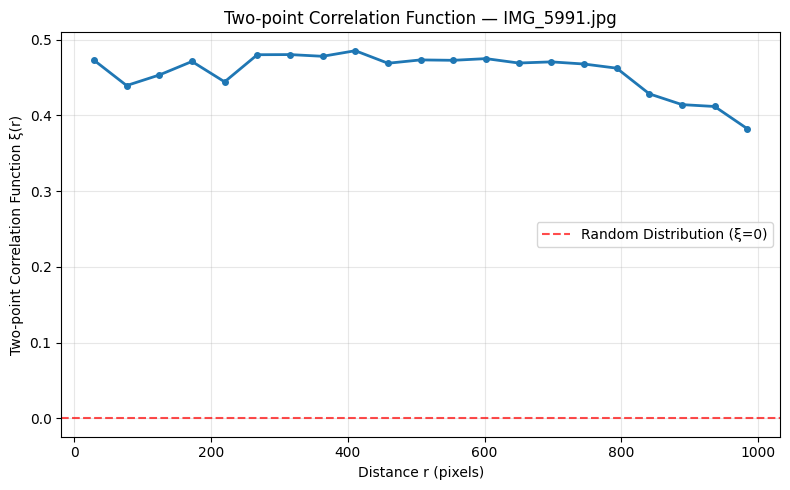


--- 分析結果の保存 ---
完全分析結果: /Users/linda/Documents/Amanogawa/outputs/results/complete_analysis_summary.json
図表保存先: /Users/linda/Documents/Amanogawa/outputs/figures

=== 分析結果サマリー ===
星の総数: 13733
フラクタル次元: 1.672
平均最近傍距離: 12.56 px
平均2点相関: 0.4572
クラスタリング特性スケール: 411.0 px

基本分析パイプライン完了！


In [13]:
# Execute Complete Analysis Pipeline
# 完全な分析パイプラインの実行

print("=== 統合分析パイプラインの開始 ===")

# 星座標の取得または検出
data, (W,H), df = load_or_detect(COORDS_CSV, IMAGE_PATH, detect_threshold=0.05)
points = df[["x","y"]].to_numpy()

print(f"画像サイズ: {W} × {H} ピクセル")
print(f"検出された星の数: {len(points)}")

if len(points) == 0:
    print("エラー: 星が検出されませんでした。処理を終了します。")
else:
    # 分析結果を格納する辞書
    analysis_results = {
        "image_info": {
            "filename": Path(IMAGE_PATH).name,
            "width_px": W,
            "height_px": H,
            "total_stars": len(points)
        }
    }
    
    print("\n--- 基本統計解析 ---")
    
    # 1. 最近傍距離分布
    nnd = nearest_neighbor_dist(points)
    nnd_stats = {
        "mean": float(np.mean(nnd)),
        "std": float(np.std(nnd)),
        "median": float(np.median(nnd))
    }
    analysis_results["nearest_neighbor"] = nnd_stats
    print(f"最近傍距離: 平均 {nnd_stats['mean']:.2f} ± {nnd_stats['std']:.2f} px")
    
    # 2. フラクタル次元
    D, eps, Ns = boxcount_fractal_dim(points, W, H)
    analysis_results["fractal_dimension"] = float(D)
    print(f"フラクタル次元: D ≈ {D:.3f}")
    
    # 3. 2点相関関数
    r_bins = np.linspace(5, min(W,H)/3, 22)
    rc, xi = two_point_correlation(points, W, H, r_bins, maxN=3500)
    
    # 相関の特徴量
    correlation_features = {
        "r_centers": rc.tolist(),
        "xi_values": xi.tolist(),
        "xi_mean": float(np.nanmean(xi)),
        "xi_max": float(np.nanmax(xi)),
        "clustering_scale": float(rc[np.nanargmax(xi)]) if not np.all(np.isnan(xi)) else None
    }
    analysis_results["two_point_correlation"] = correlation_features
    print(f"平均相関: ξ̄ = {correlation_features['xi_mean']:.4f}")
    
    print("\n--- 可視化の生成 ---")
    
    # 図1: 最近傍距離ヒストグラム
    plt.figure(figsize=(8,5))
    plt.hist(nnd, bins=50, alpha=0.7, density=True, edgecolor='black')
    plt.xlabel("Nearest Neighbor Distance (pixels)")
    plt.ylabel("Probability Density")
    plt.title(f"Nearest Neighbor Distribution — {Path(IMAGE_PATH).name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    nnd_fig_path = OUTPUT_DIR / "figures" / "nearest_neighbor_distribution.png"
    nnd_fig_path.parent.mkdir(exist_ok=True)
    plt.savefig(nnd_fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 図2: フラクタル次元プロット
    plt.figure(figsize=(8,5))
    plt.loglog(1/eps, Ns, 'o-', linewidth=2, markersize=6)
    plt.xlabel("1/Box Size")
    plt.ylabel("Number of Occupied Boxes")
    plt.title(f"Box Counting Method — Fractal Dimension D ≈ {D:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    fractal_fig_path = OUTPUT_DIR / "figures" / "fractal_dimension_plot.png"
    plt.savefig(fractal_fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 図3: 2点相関関数
    plt.figure(figsize=(8,5))
    plt.plot(rc, xi, 'o-', linewidth=2, markersize=4)
    plt.axhline(0, linestyle='--', color='red', alpha=0.7, label='Random Distribution (ξ=0)')
    plt.xlabel("Distance r (pixels)")
    plt.ylabel("Two-point Correlation Function ξ(r)")
    plt.title(f"Two-point Correlation Function — {Path(IMAGE_PATH).name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    corr_fig_path = OUTPUT_DIR / "figures" / "two_point_correlation.png"
    plt.savefig(corr_fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n--- 分析結果の保存 ---")
    
    # 総合分析結果の保存
    results_path = OUTPUT_DIR / "results" / "complete_analysis_summary.json"
    results_path.parent.mkdir(exist_ok=True)
    
    with open(results_path, 'w', encoding='utf-8') as f:
        json.dump(analysis_results, f, ensure_ascii=False, indent=2)
    
    print(f"完全分析結果: {results_path}")
    print(f"図表保存先: {OUTPUT_DIR / 'figures'}")
    
    # 結果サマリーの表示
    print("\n=== 分析結果サマリー ===")
    print(f"星の総数: {analysis_results['image_info']['total_stars']}")
    print(f"フラクタル次元: {analysis_results['fractal_dimension']:.3f}")
    print(f"平均最近傍距離: {analysis_results['nearest_neighbor']['mean']:.2f} px")
    print(f"平均2点相関: {analysis_results['two_point_correlation']['xi_mean']:.4f}")
    
    if analysis_results['two_point_correlation']['clustering_scale']:
        print(f"クラスタリング特性スケール: {analysis_results['two_point_correlation']['clustering_scale']:.1f} px")
    
    print("\n基本分析パイプライン完了！")

=== Detection Threshold Sensitivity Analysis ===
Threshold range: 0.030 - 0.080
Correlation analysis: 21 distance bins
進行状況: 1/10 (threshold=0.030) ... Complete (N=21146, D=1.768)
進行状況: 2/10 (threshold=0.036) ... Complete (N=21146, D=1.768)
進行状況: 2/10 (threshold=0.036) ... Complete (N=18215, D=1.737)
進行状況: 3/10 (threshold=0.041) ... Complete (N=18215, D=1.737)
進行状況: 3/10 (threshold=0.041) ... Complete (N=16091, D=1.709)
進行状況: 4/10 (threshold=0.047) ... Complete (N=16091, D=1.709)
進行状況: 4/10 (threshold=0.047) ... Complete (N=14511, D=1.685)
進行状況: 5/10 (threshold=0.052) ... Complete (N=14511, D=1.685)
進行状況: 5/10 (threshold=0.052) ... Complete (N=13224, D=1.663)
進行状況: 6/10 (threshold=0.058) ... Complete (N=13224, D=1.663)
進行状況: 6/10 (threshold=0.058) ... Complete (N=12178, D=1.641)
進行状況: 7/10 (threshold=0.063) ... Complete (N=12178, D=1.641)
進行状況: 7/10 (threshold=0.063) ... Complete (N=11282, D=1.621)
進行状況: 8/10 (threshold=0.069) ... Complete (N=11282, D=1.621)
進行状況: 8/10 (threshold=0.069

,threshold,N,D,xi_mean,xi_max
0,0.0300,21146,1.7681,0.4484,0.5282
1,0.0356,18215,1.7374,0.4705,0.5636
2,0.0411,16091,1.7092,0.4353,0.4950
3,0.0467,14511,1.6850,0.4741,0.5384
4,0.0522,13224,1.6628,0.3977,0.4615
5,0.0578,12178,1.6411,0.4707,0.5460
6,0.0633,11282,1.6210,0.4279,0.4962
7,0.0689,10423,1.5995,0.4485,0.4700
8,0.0744,9722,1.5798,0.4410,0.4666
9,0.0800,9079,1.5599,0.3945,0.4347


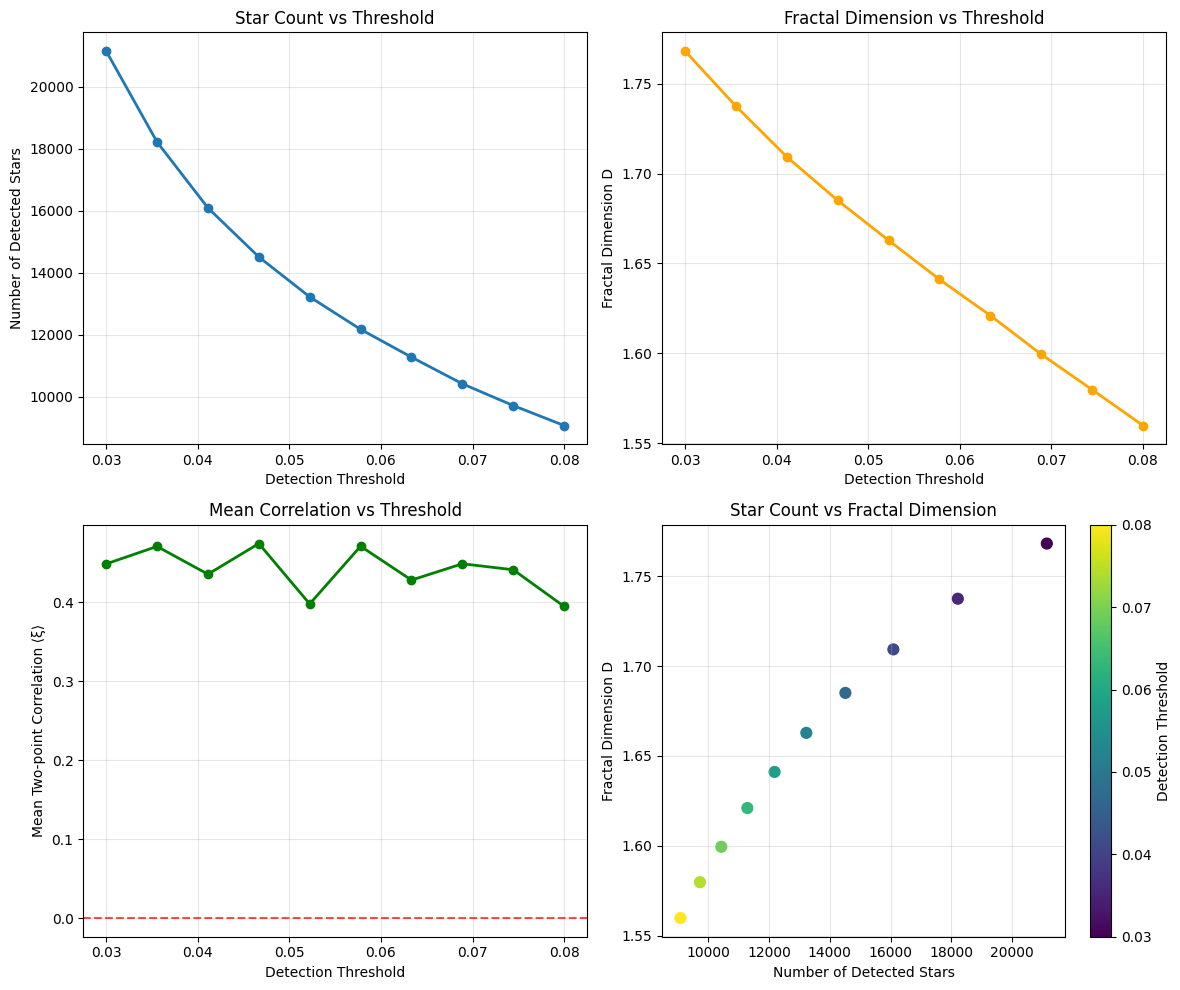


=== Sensitivity Analysis Results ===
Data saved: /Users/linda/Documents/Amanogawa/outputs/results/threshold_sensitivity_analysis.csv
Figure saved: /Users/linda/Documents/Amanogawa/outputs/figures/parameter_sensitivity_analysis.png
Recommended parameters: No suitable star count range found
Sensitivity analysis complete


In [14]:
# Parameter Sensitivity Analysis
# 検出パラメータの感度解析

print("=== Detection Threshold Sensitivity Analysis ===")

# 閾値範囲の設定
thresholds = np.linspace(0.03, 0.08, 10)
r_bins = np.linspace(5, min(W,H)/3, 22)

print(f"Threshold range: {thresholds[0]:.3f} - {thresholds[-1]:.3f}")
print(f"Correlation analysis: {len(r_bins)-1} distance bins")

# 各閾値で解析を実行
rows = []
for i, th in enumerate(thresholds):
    print(f"進行状況: {i+1}/{len(thresholds)} (threshold={th:.3f})", end=" ... ")
    
    # 星検出
    df_th = detect_stars_log(data, threshold=th)
    P = df_th[["x","y"]].to_numpy()
    
    if len(P) < 200:  # 統計的に有意な数に満たない場合
        rows.append({"threshold": th, "N": len(P), "D": np.nan, "xi_mean": np.nan})
        print(f"Insufficient stars (N={len(P)})")
        continue
    
    # フラクタル次元計算
    D, _, _ = boxcount_fractal_dim(P, W, H)
    
    # 2点相関計算
    rc, xi = two_point_correlation(P, W, H, r_bins, maxN=3500)
    
    # 結果記録
    result = {
        "threshold": th,
        "N": len(P),
        "D": float(D),
        "xi_mean": float(np.nanmean(xi)),
        "xi_max": float(np.nanmax(xi)) if not np.all(np.isnan(xi)) else np.nan
    }
    rows.append(result)
    print(f"Complete (N={len(P)}, D={D:.3f})")

# 結果をDataFrameに変換
sweep_df = pd.DataFrame(rows)
print(f"\nSensitivity analysis complete: {len(sweep_df)} data points")

# 結果の表示
display(sweep_df.round(4))

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) 星数 vs 閾値
axes[0,0].plot(sweep_df["threshold"], sweep_df["N"], 'o-', linewidth=2, markersize=6)
axes[0,0].set_xlabel("Detection Threshold")
axes[0,0].set_ylabel("Number of Detected Stars")
axes[0,0].set_title("Star Count vs Threshold")
axes[0,0].grid(True, alpha=0.3)

# 2) フラクタル次元 vs 閾値
mask_valid = ~np.isnan(sweep_df["D"])
if mask_valid.any():
    axes[0,1].plot(sweep_df["threshold"][mask_valid], sweep_df["D"][mask_valid], 'o-', 
                   linewidth=2, markersize=6, color='orange')
    axes[0,1].set_xlabel("Detection Threshold")
    axes[0,1].set_ylabel("Fractal Dimension D")
    axes[0,1].set_title("Fractal Dimension vs Threshold")
    axes[0,1].grid(True, alpha=0.3)

# 3) 平均相関 vs 閾値
mask_valid = ~np.isnan(sweep_df["xi_mean"])
if mask_valid.any():
    axes[1,0].plot(sweep_df["threshold"][mask_valid], sweep_df["xi_mean"][mask_valid], 'o-',
                   linewidth=2, markersize=6, color='green')
    axes[1,0].axhline(0, linestyle='--', color='red', alpha=0.7)
    axes[1,0].set_xlabel("Detection Threshold")
    axes[1,0].set_ylabel("Mean Two-point Correlation ⟨ξ⟩")
    axes[1,0].set_title("Mean Correlation vs Threshold")
    axes[1,0].grid(True, alpha=0.3)

# 4) 星数-フラクタル次元の関係
mask_both = ~(np.isnan(sweep_df["D"]) | np.isnan(sweep_df["N"]))
if mask_both.any():
    axes[1,1].scatter(sweep_df["N"][mask_both], sweep_df["D"][mask_both], 
                      c=sweep_df["threshold"][mask_both], s=60, cmap='viridis')
    axes[1,1].set_xlabel("Number of Detected Stars")
    axes[1,1].set_ylabel("Fractal Dimension D")
    axes[1,1].set_title("Star Count vs Fractal Dimension")
    cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
    cbar.set_label("Detection Threshold")
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()

# 図の保存
sensitivity_fig_path = OUTPUT_DIR / "figures" / "parameter_sensitivity_analysis.png"
plt.savefig(sensitivity_fig_path, dpi=150, bbox_inches='tight')
plt.show()

# CSV保存
sweep_csv_path = OUTPUT_DIR / "results" / "threshold_sensitivity_analysis.csv"
sweep_df.to_csv(sweep_csv_path, index=False)

print(f"\n=== Sensitivity Analysis Results ===")
print(f"Data saved: {sweep_csv_path}")
print(f"Figure saved: {sensitivity_fig_path}")

# 推奨パラメータの提案
if len(sweep_df[~np.isnan(sweep_df["D"])]) > 0:
    # 適度な星数(1000-5000)で最も安定したフラクタル次元を持つ閾値を推奨
    good_range = sweep_df[(sweep_df["N"] >= 1000) & (sweep_df["N"] <= 5000)]
    if len(good_range) > 0:
        best_idx = good_range["D"].idxmax()
        best_threshold = sweep_df.loc[best_idx, "threshold"]
        best_N = sweep_df.loc[best_idx, "N"]
        best_D = sweep_df.loc[best_idx, "D"]
        print(f"Recommended threshold: {best_threshold:.3f} (stars: {best_N}, D: {best_D:.3f})")
    else:
        print("Recommended parameters: No suitable star count range found")

print("Sensitivity analysis complete")

=== 星の等級解析と明度別空間分布 ===
アパーチャフォトメトリ実行中...
フォトメトリ成功: 13730/13733 星
等級範囲: -9.37 ～ -3.31 mag

Magnitude-based classification:
Bright stars (≤-7.46 mag): 4577 objects
Mid stars (-7.46--6.89 mag): 4577 objects
Faint stars (>-6.89 mag): 4576 objects
フォトメトリ成功: 13730/13733 星
等級範囲: -9.37 ～ -3.31 mag

Magnitude-based classification:
Bright stars (≤-7.46 mag): 4577 objects
Mid stars (-7.46--6.89 mag): 4577 objects
Faint stars (>-6.89 mag): 4576 objects


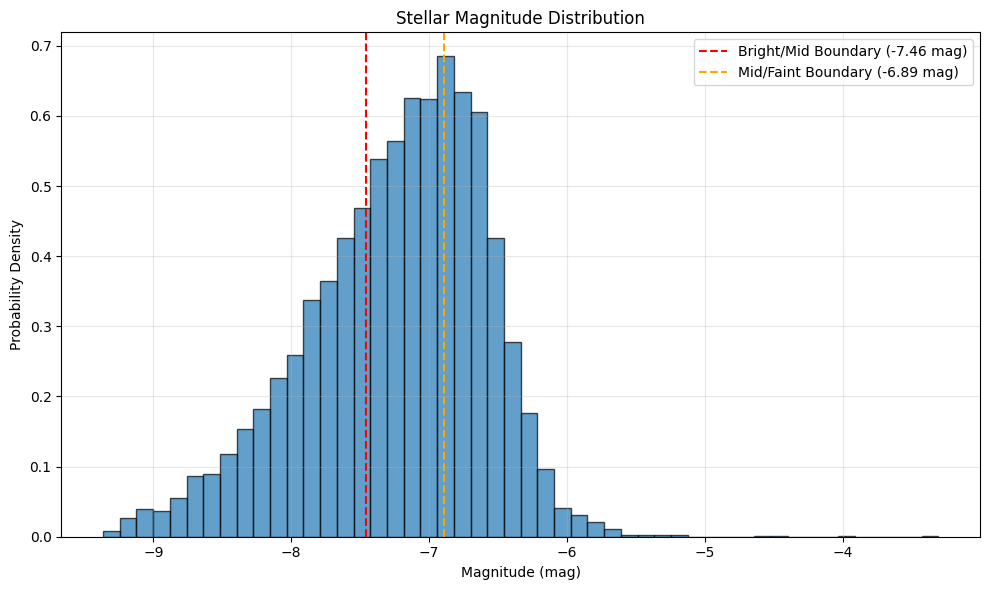

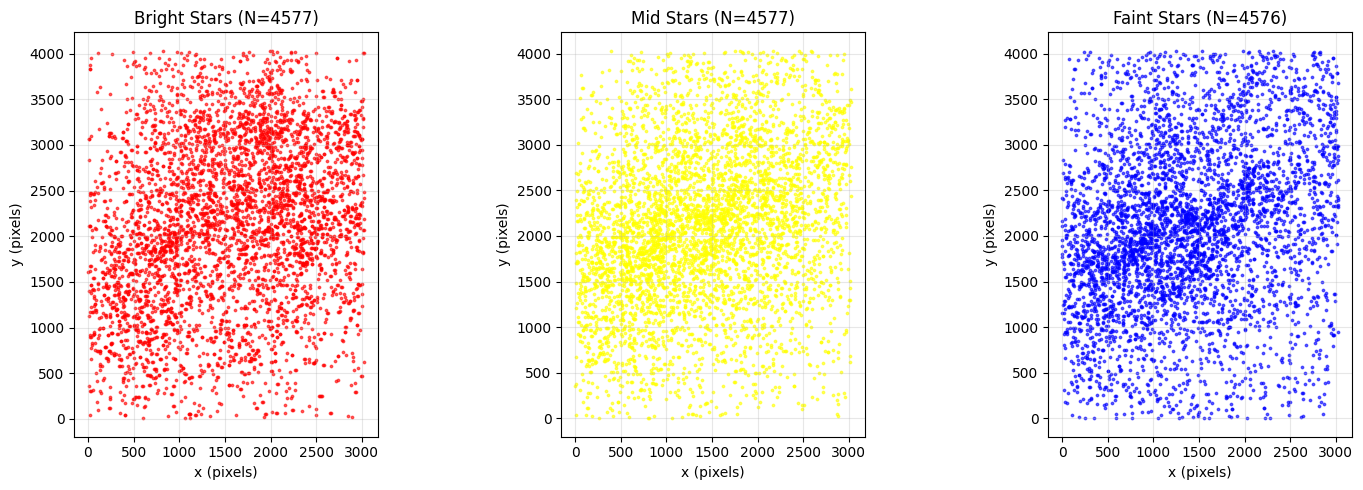


Magnitude-based two-point correlation analysis...
Bright: Analyzing... (N=4577)
Mid: Analyzing... (N=4577)
Mid: Analyzing... (N=4577)
Faint: Analyzing... (N=4576)
Faint: Analyzing... (N=4576)


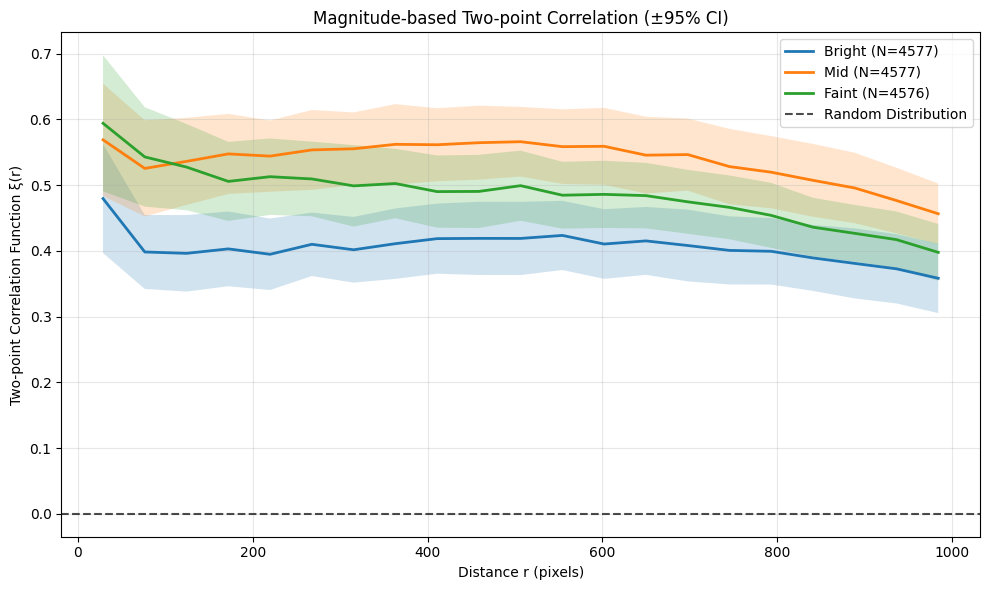


=== Magnitude Analysis Results ===
Measurement success rate: 100.0%
Magnitude range: -9.37 ~ -3.31 mag
Bright stars mean correlation: 0.4052
Mid stars mean correlation: 0.5370
Faint stars mean correlation: 0.4857
Results saved: /Users/linda/Documents/Amanogawa/outputs/results/magnitude_analysis.json
Magnitude analysis complete!


In [15]:
# Magnitude Analysis and Luminosity-based Clustering
# 等級解析と明度別クラスタリング解析

print("=== 星の等級解析と明度別空間分布 ===")

# アパーチャフォトメトリによる等級測定
print("アパーチャフォトメトリ実行中...")
mags, valid_idx = simple_aperture_mags_with_indices(data, points, r=2, r_in=6, r_out=10, max_samples=15000)
pts = points[valid_idx]

print(f"フォトメトリ成功: {len(mags)}/{len(points)} 星")
print(f"等級範囲: {np.min(mags):.2f} ～ {np.max(mags):.2f} mag")

if len(mags) == 0:
    print("エラー: フォトメトリに失敗しました")
else:
    # 3層等級分類
    q = np.quantile(mags, [1/3, 2/3])
    
    layers = {
        "Bright": pts[mags <= q[0]],    # 明るい星 (上位1/3)
        "Mid":    pts[(mags > q[0]) & (mags <= q[1])],  # 中間星
        "Faint":  pts[mags > q[1]]      # 暗い星 (下位1/3)
    }
    
    print(f"\nMagnitude-based classification:")
    print(f"Bright stars (≤{q[0]:.2f} mag): {len(layers['Bright'])} objects")
    print(f"Mid stars ({q[0]:.2f}-{q[1]:.2f} mag): {len(layers['Mid'])} objects") 
    print(f"Faint stars (>{q[1]:.2f} mag): {len(layers['Faint'])} objects")
    
    # 等級ヒストグラム
    plt.figure(figsize=(10, 6))
    plt.hist(mags, bins=50, alpha=0.7, density=True, edgecolor='black')
    plt.axvline(q[0], color='red', linestyle='--', label=f'Bright/Mid Boundary ({q[0]:.2f} mag)')
    plt.axvline(q[1], color='orange', linestyle='--', label=f'Mid/Faint Boundary ({q[1]:.2f} mag)')
    plt.xlabel("Magnitude (mag)")
    plt.ylabel("Probability Density")  
    plt.title("Stellar Magnitude Distribution")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    mag_hist_path = OUTPUT_DIR / "figures" / "magnitude_distribution.png"
    plt.savefig(mag_hist_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 明度別空間分布
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['red', 'yellow', 'blue']
    
    for i, (name, P) in enumerate(layers.items()):
        if len(P) > 0:
            axes[i].scatter(P[:, 0], P[:, 1], s=3, c=colors[i], alpha=0.6)
            axes[i].set_title(f'{name} Stars (N={len(P)})')
            axes[i].set_xlabel('x (pixels)')
            axes[i].set_ylabel('y (pixels)')
            axes[i].set_aspect('equal')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    spatial_dist_path = OUTPUT_DIR / "figures" / "magnitude_spatial_distribution.png"
    plt.savefig(spatial_dist_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 明度別2点相関解析（誤差付き）
    def xi_with_errors(P, W, H, r_bins, B=100, R=3):
        """ブートストラップによる2点相関の誤差推定"""
        RR_acc = np.zeros(len(r_bins)-1)
        for _ in range(R):
            _, xi_tmp = two_point_correlation(P, W, H, r_bins, maxN=3500)
            RR_acc += (xi_tmp + 1.0)
        RR_mean_like = RR_acc / R
        
        # ブートストラップ
        XIs = []
        n = len(P)
        for _ in range(B):
            idx = np.random.randint(0, n, n)
            Pb = P[idx]
            _, xi_b = two_point_correlation(Pb, W, H, r_bins, maxN=3500)
            XIs.append(xi_b)
        
        XIs = np.vstack(XIs)
        xi_mean = XIs.mean(axis=0)
        xi_std = XIs.std(axis=0, ddof=1)
        rc = 0.5*(r_bins[1:]+r_bins[:-1])
        return rc, xi_mean, xi_std
    
    # 相関解析実行
    print("\nMagnitude-based two-point correlation analysis...")
    r_bins = np.linspace(5, min(W,H)/3, 22)
    
    plt.figure(figsize=(10, 6))
    correlation_results = {}
    
    for name, P in layers.items():
        if len(P) < 300:
            print(f"{name}: Skip (N={len(P)} < 300)")
            continue
            
        print(f"{name}: Analyzing... (N={len(P)})")
        rc, xi_m, xi_s = xi_with_errors(P, W, H, r_bins, B=100, R=3)
        
        # プロット
        plt.plot(rc, xi_m, label=f"{name} (N={len(P)})", linewidth=2)
        plt.fill_between(rc, xi_m-1.96*xi_s, xi_m+1.96*xi_s, alpha=0.2)
        
        # 結果保存
        correlation_results[name] = {
            "N": len(P),
            "r_centers": rc.tolist(),
            "xi_mean": xi_m.tolist(),
            "xi_std": xi_s.tolist(),
            "overall_xi_mean": float(np.nanmean(xi_m))
        }
    
    plt.axhline(0, linestyle='--', color='black', alpha=0.7, label='Random Distribution')
    plt.xlabel("Distance r (pixels)")
    plt.ylabel("Two-point Correlation Function ξ(r)")
    plt.title("Magnitude-based Two-point Correlation (±95% CI)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    mag_corr_path = OUTPUT_DIR / "figures" / "magnitude_correlation_analysis.png"
    plt.savefig(mag_corr_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 結果保存
    magnitude_analysis = {
        "photometry_summary": {
            "total_measured": len(mags),
            "magnitude_range": [float(np.min(mags)), float(np.max(mags))],
            "magnitude_quantiles": [float(q[0]), float(q[1])],
            "layer_counts": {name: len(P) for name, P in layers.items()}
        },
        "correlation_by_magnitude": correlation_results
    }
    
    mag_results_path = OUTPUT_DIR / "results" / "magnitude_analysis.json"
    with open(mag_results_path, 'w', encoding='utf-8') as f:
        json.dump(magnitude_analysis, f, ensure_ascii=False, indent=2)
    
    print(f"\n=== Magnitude Analysis Results ===")
    print(f"Measurement success rate: {len(mags)/len(points)*100:.1f}%")
    print(f"Magnitude range: {np.min(mags):.2f} ~ {np.max(mags):.2f} mag")
    
    for name, result in correlation_results.items():
        print(f"{name} stars mean correlation: {result['overall_xi_mean']:.4f}")
    
    print(f"Results saved: {mag_results_path}")
    print("Magnitude analysis complete!")

=== Milky Way Band Width Measurement Analysis ===
Estimating principal axis direction...
Estimated principal axis angle: -120.0° (from x-axis)
Profile analysis: 140 bins
Perpendicular coordinate range: -26.0 ~ 4404.3 pixels
Estimated background level: 7.0
Peak position: 1730.3 pixels
Initial width estimate: 726.7 pixels
Fitting range: 78/140 bins
Fitting successful:
  Gaussian FWHM: 1590.2 pixels
  Lorentzian FWHM: 2307.3 pixels
  Empirical FWHM: 1484.7 pixels


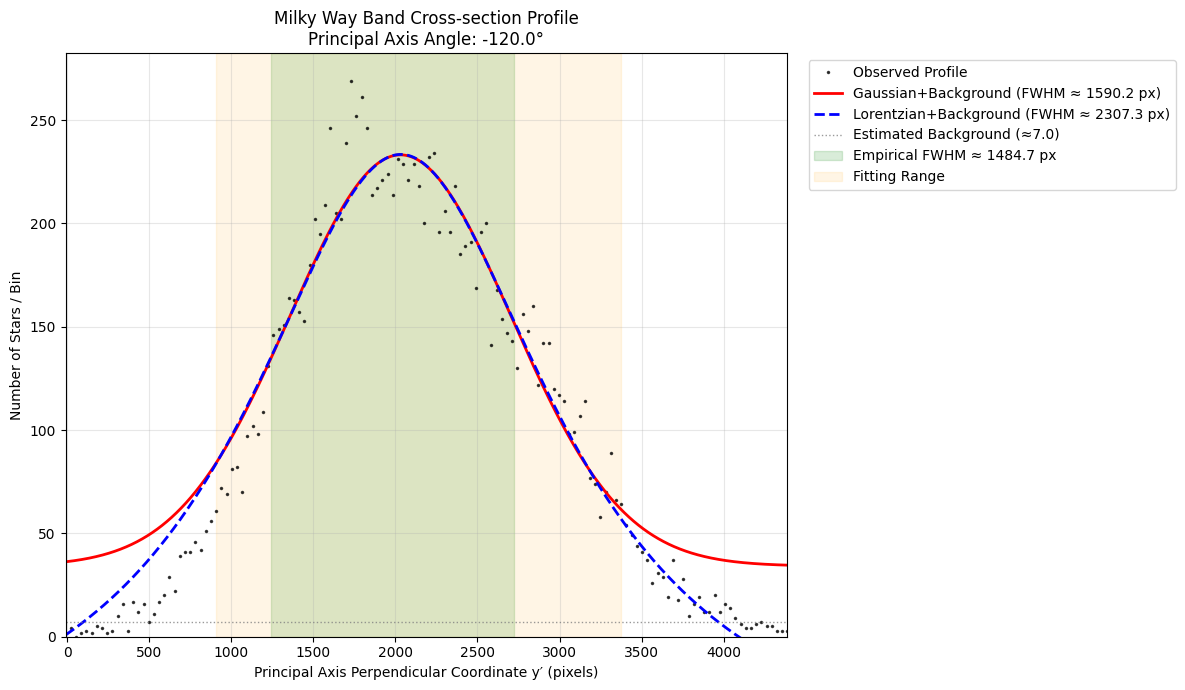


=== Band Width Analysis Results ===
Principal axis angle: -120.0°
Gaussian width: 1590.2 px
Lorentzian width: 2307.3 px
Empirical width: 1484.7 px
Angular conversion (plate scale = 67.0"/px):
  Gaussian: 1774.68 arcmin
  Lorentzian: 2574.94 arcmin
  Empirical: 1656.93 arcmin
Results saved: /Users/linda/Documents/Amanogawa/outputs/results/band_width_analysis.json
Figure saved: /Users/linda/Documents/Amanogawa/outputs/figures/milky_way_band_profile.png
Band width analysis complete!


In [16]:
# Milky Way Band Width Analysis
# 天の川バンド幅測定とプロファイル解析

print("=== Milky Way Band Width Measurement Analysis ===")

# PCAによる主軸方向の推定
print("Estimating principal axis direction...")
ang_deg, center = pca_principal_axis(points, W, H, bins_x=60)
print(f"Estimated principal axis angle: {ang_deg:.1f}° (from x-axis)")

# 座標系を主軸に合わせて回転
P_rot = rotate_points(points, -ang_deg, np.array(center))
y_perp = P_rot[:, 1]  # 主軸に垂直な方向の座標

# プロファイルヒストグラム作成
bins = 140
hist, edges = np.histogram(y_perp, bins=bins)
centers = 0.5*(edges[1:] + edges[:-1])

print(f"Profile analysis: {bins} bins")
print(f"Perpendicular coordinate range: {y_perp.min():.1f} ~ {y_perp.max():.1f} pixels")

# 背景推定（両端の下位分位を使用）
edge_frac = 0.15
k = int(max(3, bins*edge_frac))
bg_samples = np.concatenate([hist[:k], hist[-k:]])
B0 = np.median(bg_samples)

print(f"Estimated background level: {B0:.1f}")

# フィット用モデル関数
def gauss_bg(x, A, mu, sigma, B):
    """ガウス関数+背景"""
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + B

def lorentz_bg(x, A, x0, gamma, B):
    """ローレンツ関数+背景"""
    return A*(gamma**2/((x-x0)**2 + gamma**2)) + B

# フィット範囲の自動決定
peak_idx = np.argmax(hist)
peak = hist[peak_idx]
amp0 = max(peak - B0, 1.0)
mu0 = centers[peak_idx]
sig0 = np.std(y_perp)

print(f"Peak position: {mu0:.1f} pixels")
print(f"Initial width estimate: {sig0:.1f} pixels")

# 山の部分のみをフィット対象とする
mask_peak = hist >= (B0 + 0.2*amp0)
x_fit = centers[mask_peak]
y_fit = hist[mask_peak]

print(f"Fitting range: {len(x_fit)}/{len(centers)} bins")

# 初期パラメータ
p0_g = (amp0, mu0, sig0, B0)
p0_l = (amp0, mu0, max(sig0, 1.0), B0)

try:
    # ガウシアンフィット
    pg, cov_g = curve_fit(gauss_bg, x_fit, y_fit, p0=p0_g, maxfev=20000)
    
    # ローレンツィアンフィット
    pl, cov_l = curve_fit(lorentz_bg, x_fit, y_fit, p0=p0_l, maxfev=20000)
    
    # FWHM計算
    FWHM_g = 2.3548 * abs(pg[2])  # ガウシアン
    FWHM_l = 2 * abs(pl[2])       # ローレンツィアン
    
    print(f"Fitting successful:")
    print(f"  Gaussian FWHM: {FWHM_g:.1f} pixels")
    print(f"  Lorentzian FWHM: {FWHM_l:.1f} pixels")
    
    # 実データ半値幅（empirical FWHM）
    profile_sub = hist - B0
    profile_sub[profile_sub < 0] = 0
    peak_val = profile_sub[peak_idx]
    half = peak_val * 0.5
    
    def half_cross_x(centers, prof, start, direction):
        """半値交点の線形補間による推定"""
        i = start
        while 0 <= i+direction < len(prof) and prof[i+direction] > half:
            i += direction
        j = i + direction
        if j < 0 or j >= len(prof):
            return centers[i]
        
        # 線形補間
        x1, y1 = centers[i], prof[i]
        x2, y2 = centers[j], prof[j]
        if y2 == y1:
            return x1
        return x1 + (half - y1) * (x2 - x1) / (y2 - y1)
    
    x_left = half_cross_x(centers, profile_sub, peak_idx, -1)
    x_right = half_cross_x(centers, profile_sub, peak_idx, +1)
    FWHM_emp = x_right - x_left
    
    print(f"  Empirical FWHM: {FWHM_emp:.1f} pixels")
    
    # プロファイル可視化
    xplot = np.linspace(centers.min(), centers.max(), 1500)
    
    plt.figure(figsize=(12, 7))
    
    # 観測データ
    plt.plot(centers, hist, "k.", ms=3, label="Observed Profile", alpha=0.7)
    
    # フィット曲線
    plt.plot(xplot, gauss_bg(xplot, *pg), "-", lw=2, 
             label=f"Gaussian+Background (FWHM ≈ {FWHM_g:.1f} px)", color='red')
    plt.plot(xplot, lorentz_bg(xplot, *pl), "--", lw=2,
             label=f"Lorentzian+Background (FWHM ≈ {FWHM_l:.1f} px)", color='blue')
    
    # 背景線
    plt.axhline(B0, lw=1, linestyle=":", color='gray', alpha=0.8,
                label=f"Estimated Background (≈{B0:.1f})")
    
    # 実データ半値幅のシェーディング
    plt.fill_between([x_left, x_right], [0, 0], [max(hist)*1.05, max(hist)*1.05],
                     alpha=0.15, color='green',
                     label=f"Empirical FWHM ≈ {FWHM_emp:.1f} px")
    
    # フィット範囲の表示
    plt.fill_between(x_fit, 0, max(hist)*1.05, alpha=0.1, color='orange',
                     label="Fitting Range")
    
    plt.xlabel("Principal Axis Perpendicular Coordinate y′ (pixels)")
    plt.ylabel("Number of Stars / Bin")
    plt.title(f"Milky Way Band Cross-section Profile\nPrincipal Axis Angle: {ang_deg:.1f}°")
    plt.xlim(centers.min(), centers.max())
    plt.ylim(0, max(hist)*1.05)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    band_profile_path = OUTPUT_DIR / "figures" / "milky_way_band_profile.png"
    plt.savefig(band_profile_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 角度スケール換算（plate scaleがある場合）
    PLATE_SCALE_ARCSEC = 66.959  # astrometry.netから取得した値
    
    # 結果まとめ
    band_analysis = {
        "geometry": {
            "principal_axis_angle_deg": float(ang_deg),
            "center_x_px": float(center[0]),
            "center_y_px": float(center[1])
        },
        "profile_analysis": {
            "fit_range_bins": int(mask_peak.sum()),
            "background_median": float(B0),
            "peak_position_px": float(mu0),
            "peak_amplitude": float(peak - B0)
        },
        "width_measurements": {
            "FWHM_gaussian_px": float(FWHM_g),
            "FWHM_lorentz_px": float(FWHM_l),
            "FWHM_empirical_px": float(FWHM_emp)
        }
    }
    
    # 角度スケール換算
    if PLATE_SCALE_ARCSEC is not None:
        px2deg = PLATE_SCALE_ARCSEC / 3600.0
        band_analysis["width_measurements"].update({
            "FWHM_gaussian_deg": float(FWHM_g * px2deg),
            "FWHM_lorentz_deg": float(FWHM_l * px2deg),
            "FWHM_empirical_deg": float(FWHM_emp * px2deg),
            "FWHM_gaussian_arcmin": float(FWHM_g * PLATE_SCALE_ARCSEC / 60.0),
            "FWHM_lorentz_arcmin": float(FWHM_l * PLATE_SCALE_ARCSEC / 60.0),
            "FWHM_empirical_arcmin": float(FWHM_emp * PLATE_SCALE_ARCSEC / 60.0)
        })
    
    # 結果保存
    band_results_path = OUTPUT_DIR / "results" / "band_width_analysis.json"
    with open(band_results_path, 'w', encoding='utf-8') as f:
        json.dump(band_analysis, f, ensure_ascii=False, indent=2)
    
    print(f"\n=== Band Width Analysis Results ===")
    print(f"Principal axis angle: {ang_deg:.1f}°")
    print(f"Gaussian width: {FWHM_g:.1f} px")
    print(f"Lorentzian width: {FWHM_l:.1f} px")
    print(f"Empirical width: {FWHM_emp:.1f} px")
    
    if PLATE_SCALE_ARCSEC is not None:
        print(f"Angular conversion (plate scale = {PLATE_SCALE_ARCSEC:.1f}\"/px):")
        print(f"  Gaussian: {FWHM_g * PLATE_SCALE_ARCSEC / 60.0:.2f} arcmin")
        print(f"  Lorentzian: {FWHM_l * PLATE_SCALE_ARCSEC / 60.0:.2f} arcmin")
        print(f"  Empirical: {FWHM_emp * PLATE_SCALE_ARCSEC / 60.0:.2f} arcmin")
    
    print(f"Results saved: {band_results_path}")
    print(f"Figure saved: {band_profile_path}")

except Exception as e:
    print(f"Fitting error: {e}")
    print("Please adjust parameters and re-run")

print("Band width analysis complete!")

=== Detailed Spatial Statistics Analysis ===
1. Nearest neighbor distribution analysis
Mean nearest neighbor distance: 12.56 ± 8.52 px
Median: 9.06 px
Quartile range: 7.07 - 15.52 px
Expected value for random distribution: 14.90 px
Observed/Expected ratio: 0.843


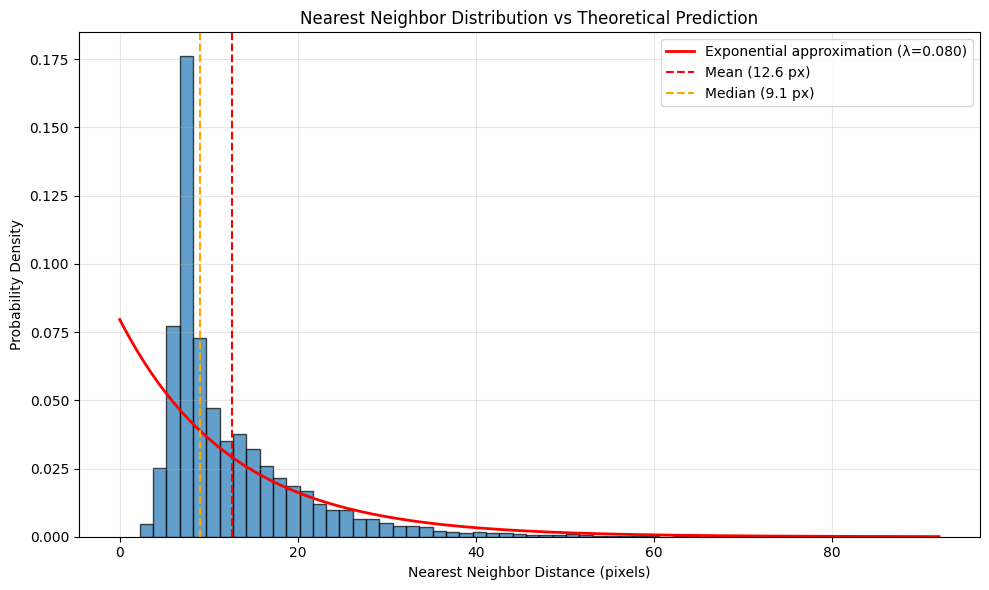


2. Detailed fractal dimension analysis
Fractal dimension: D = 1.5671
Fit coefficient of determination: R² = 0.9784
Fractal dimension: D = 1.5671
Fit coefficient of determination: R² = 0.9784


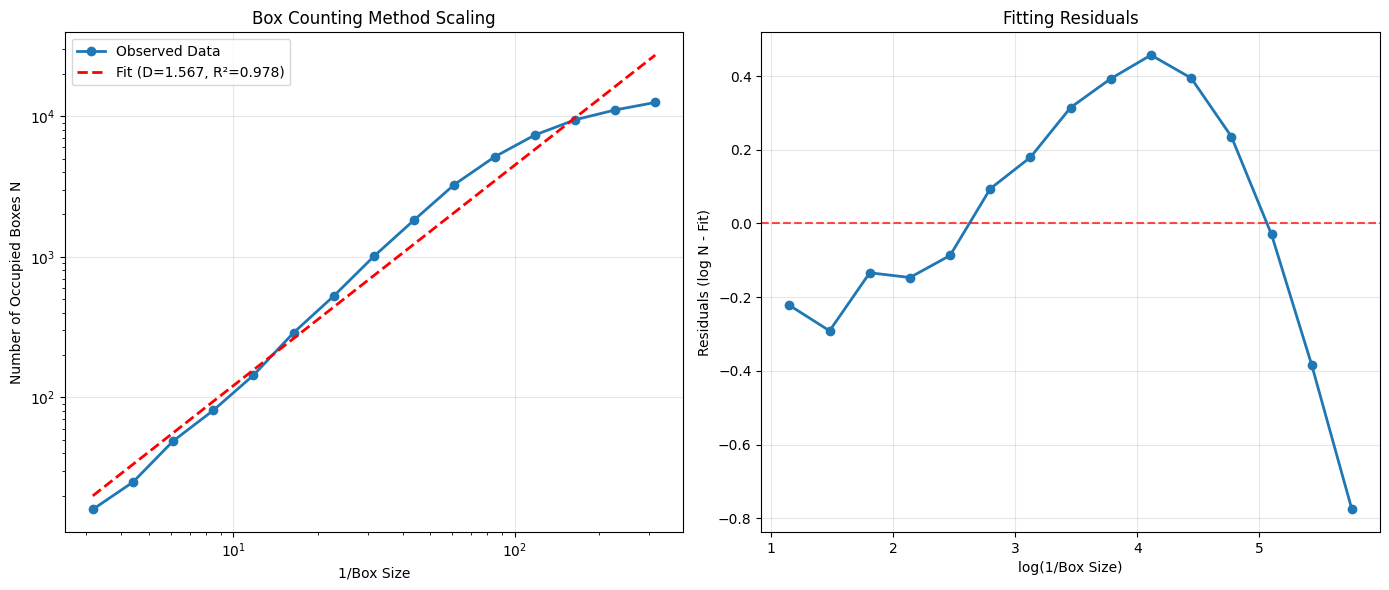


3. Detailed two-point correlation function analysis
Correlation length: r₀ ≈ 6732.0 px
Correlation length: r₀ ≈ 6732.0 px


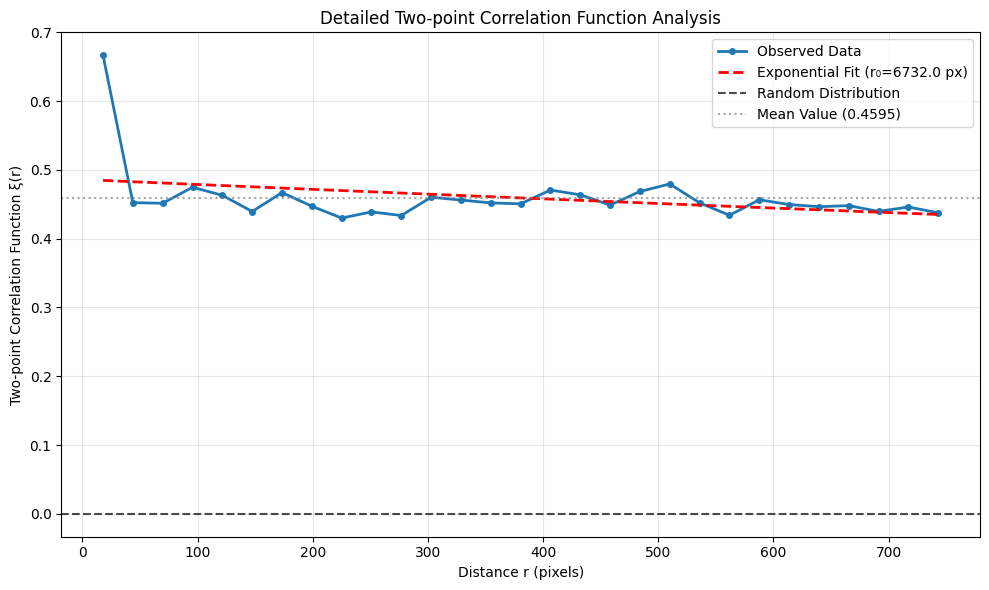


4. Comprehensive spatial statistics evaluation
Clustering evaluation:
  NND ratio (observed/random): 0.843
    → Regular arrangement tendency
  Fractal dimension: 1.567
    → Linear/filamentary structure
  Mean two-point correlation: 0.4595
    → Positive spatial correlation (clustering)

Detailed analysis results saved: /Users/linda/Documents/Amanogawa/outputs/results/spatial_statistics_detailed.json
Detailed spatial statistics analysis complete!


In [17]:
# Detailed Spatial Statistics Analysis
# 詳細空間統計解析

print("=== Detailed Spatial Statistics Analysis ===")

# 1. 最近傍距離分布の詳細解析
print("1. Nearest neighbor distribution analysis")
nnd = nearest_neighbor_dist(points)

# 統計量計算
nnd_stats = {
    "count": len(nnd),
    "mean": float(np.mean(nnd)),
    "std": float(np.std(nnd)),
    "median": float(np.median(nnd)),
    "q25": float(np.percentile(nnd, 25)),
    "q75": float(np.percentile(nnd, 75)),
    "min": float(np.min(nnd)),
    "max": float(np.max(nnd))
}

print(f"Mean nearest neighbor distance: {nnd_stats['mean']:.2f} ± {nnd_stats['std']:.2f} px")
print(f"Median: {nnd_stats['median']:.2f} px")
print(f"Quartile range: {nnd_stats['q25']:.2f} - {nnd_stats['q75']:.2f} px")

# 理論分布との比較
# ランダム分布での期待値: E[d] = 1/(2√ρ), ρ = N/A
area = W * H
density = len(points) / area
expected_nnd = 1 / (2 * np.sqrt(density))
print(f"Expected value for random distribution: {expected_nnd:.2f} px")
print(f"Observed/Expected ratio: {nnd_stats['mean']/expected_nnd:.3f}")

# ヒストグラム
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(nnd, bins=60, density=True, alpha=0.7, edgecolor='black')

# 理論曲線（指数分布近似）
x_theory = np.linspace(0, np.max(nnd), 200)
lambda_param = 1/nnd_stats['mean']
y_theory = lambda_param * np.exp(-lambda_param * x_theory)
plt.plot(x_theory, y_theory, 'r-', linewidth=2, label=f'Exponential approximation (λ={lambda_param:.3f})')

plt.axvline(nnd_stats['mean'], color='red', linestyle='--', 
            label=f"Mean ({nnd_stats['mean']:.1f} px)")
plt.axvline(nnd_stats['median'], color='orange', linestyle='--',
            label=f"Median ({nnd_stats['median']:.1f} px)")

plt.xlabel("Nearest Neighbor Distance (pixels)")
plt.ylabel("Probability Density")
plt.title("Nearest Neighbor Distribution vs Theoretical Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

nnd_detail_path = OUTPUT_DIR / "figures" / "nearest_neighbor_detailed.png"
plt.savefig(nnd_detail_path, dpi=150, bbox_inches='tight')
plt.show()

# 2. フラクタル次元の詳細解析
print("\n2. Detailed fractal dimension analysis")
D, eps, Ns = boxcount_fractal_dim(points, W, H, exp_from=-0.5, exp_to=-2.5, steps=15)

# フィット品質評価
log_eps_inv = np.log(1/eps)
log_Ns = np.log(Ns)
slope, intercept = np.polyfit(log_eps_inv, log_Ns, 1)
r_squared = np.corrcoef(log_eps_inv, log_Ns)[0,1]**2

print(f"Fractal dimension: D = {D:.4f}")
print(f"Fit coefficient of determination: R² = {r_squared:.4f}")

# 詳細プロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# スケーリングプロット
ax1.loglog(1/eps, Ns, 'o-', linewidth=2, markersize=6, label='Observed Data')
ax1.loglog(1/eps, np.exp(intercept) * (1/eps)**slope, 'r--', linewidth=2,
           label=f'Fit (D={D:.3f}, R²={r_squared:.3f})')
ax1.set_xlabel("1/Box Size")
ax1.set_ylabel("Number of Occupied Boxes N")
ax1.set_title("Box Counting Method Scaling")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 残差プロット
fitted = slope * log_eps_inv + intercept
residuals = log_Ns - fitted
ax2.plot(log_eps_inv, residuals, 'o-', linewidth=2, markersize=6)
ax2.axhline(0, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel("log(1/Box Size)")
ax2.set_ylabel("Residuals (log N - Fit)")
ax2.set_title("Fitting Residuals")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
fractal_detail_path = OUTPUT_DIR / "figures" / "fractal_dimension_detailed.png"
plt.savefig(fractal_detail_path, dpi=150, bbox_inches='tight')
plt.show()

# 3. 2点相関関数の詳細解析
print("\n3. Detailed two-point correlation function analysis")
r_bins = np.linspace(5, min(W,H)/4, 30)  # より細かい分解能
rc, xi = two_point_correlation(points, W, H, r_bins, maxN=4000)

# 相関長の推定
positive_xi = xi[xi > 0]
positive_r = rc[xi > 0]

if len(positive_xi) > 0:
    # 指数関数フィット: ξ(r) = A * exp(-r/r0)
    try:
        def exp_corr(r, A, r0):
            return A * np.exp(-r/r0)
        
        popt, pcov = curve_fit(exp_corr, positive_r, positive_xi, 
                              p0=[np.max(positive_xi), positive_r[0]])
        correlation_length = popt[1]
        print(f"Correlation length: r₀ ≈ {correlation_length:.1f} px")
    except:
        correlation_length = None
        print("Failed to fit correlation length")
else:
    correlation_length = None
    print("No positive correlation found")

# 詳細プロット
plt.figure(figsize=(10, 6))
plt.plot(rc, xi, 'o-', linewidth=2, markersize=4, label='Observed Data')

if correlation_length is not None:
    r_theory = np.linspace(rc[0], rc[-1], 100)
    xi_theory = exp_corr(r_theory, *popt)
    plt.plot(r_theory, xi_theory, 'r--', linewidth=2,
             label=f'Exponential Fit (r₀={correlation_length:.1f} px)')

plt.axhline(0, linestyle='--', color='black', alpha=0.7, label='Random Distribution')
plt.axhline(np.mean(xi), linestyle=':', color='gray', alpha=0.7,
            label=f'Mean Value ({np.mean(xi):.4f})')

plt.xlabel("Distance r (pixels)")
plt.ylabel("Two-point Correlation Function ξ(r)")
plt.title("Detailed Two-point Correlation Function Analysis")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

corr_detail_path = OUTPUT_DIR / "figures" / "correlation_function_detailed.png"
plt.savefig(corr_detail_path, dpi=150, bbox_inches='tight')
plt.show()

# 4. 空間統計の総合評価
print("\n4. Comprehensive spatial statistics evaluation")

# クラスタリング度合いの評価
clustering_metrics = {
    "nnd_ratio": nnd_stats['mean'] / expected_nnd,
    "fractal_dimension": float(D),
    "fractal_fit_quality": float(r_squared),
    "mean_correlation": float(np.nanmean(xi)),
    "max_correlation": float(np.nanmax(xi)) if not np.all(np.isnan(xi)) else None,
    "correlation_length_px": float(correlation_length) if correlation_length else None
}

print("Clustering evaluation:")
print(f"  NND ratio (observed/random): {clustering_metrics['nnd_ratio']:.3f}")
if clustering_metrics['nnd_ratio'] < 1:
    print("    → Regular arrangement tendency")
elif clustering_metrics['nnd_ratio'] > 1:
    print("    → Clustering tendency")
else:
    print("    → Random distribution")

print(f"  Fractal dimension: {clustering_metrics['fractal_dimension']:.3f}")
if clustering_metrics['fractal_dimension'] < 2:
    print("    → Linear/filamentary structure")
else:
    print("    → Areal distribution")

print(f"  Mean two-point correlation: {clustering_metrics['mean_correlation']:.4f}")
if clustering_metrics['mean_correlation'] > 0:
    print("    → Positive spatial correlation (clustering)")
elif clustering_metrics['mean_correlation'] < 0:
    print("    → Negative spatial correlation (repulsion)")
else:
    print("    → No correlation (random)")

# 結果保存
spatial_stats_detailed = {
    "nearest_neighbor_distribution": nnd_stats,
    "fractal_analysis": {
        "dimension": float(D),
        "fit_r_squared": float(r_squared),
        "scale_range": [float(eps[-1]), float(eps[0])],
        "box_counts": Ns.tolist()
    },
    "correlation_function": {
        "r_centers": rc.tolist(),
        "xi_values": xi.tolist(),
        "correlation_length_px": float(correlation_length) if correlation_length else None
    },
    "clustering_evaluation": clustering_metrics
}

spatial_detail_path = OUTPUT_DIR / "results" / "spatial_statistics_detailed.json"
with open(spatial_detail_path, 'w', encoding='utf-8') as f:
    json.dump(spatial_stats_detailed, f, ensure_ascii=False, indent=2)

print(f"\nDetailed analysis results saved: {spatial_detail_path}")
print("Detailed spatial statistics analysis complete!")

In [18]:
# Analysis Summary and Results Export  
# 解析結果の総合まとめとエクスポート

print("=== 天の川バンド解析総合まとめ ===")

# 1. 分析結果ファイルの確認
results_dir = OUTPUT_DIR / "results"
figures_dir = OUTPUT_DIR / "figures"

print(f"出力ディレクトリ: {OUTPUT_DIR}")
print(f"結果ファイル: {results_dir}")
print(f"図表ファイル: {figures_dir}")

# 生成されたファイルのリスト
generated_files = {
    "results": [],
    "figures": [],
    "data": []
}

if results_dir.exists():
    for file in results_dir.glob("*.json"):
        generated_files["results"].append(str(file.name))

if figures_dir.exists():
    for file in figures_dir.glob("*.png"):
        generated_files["figures"].append(str(file.name))

if (OUTPUT_DIR / "IMG_5991_star_coords.csv").exists():
    generated_files["data"].append("IMG_5991_star_coords.csv")

print("\n--- 生成されたファイル一覧 ---")
print("結果ファイル (JSON):")
for f in generated_files["results"]:
    print(f"  - {f}")

print("図表ファイル (PNG):")
for f in generated_files["figures"]:
    print(f"  - {f}")

print("データファイル (CSV):")
for f in generated_files["data"]:
    print(f"  - {f}")

# 2. 統合結果サマリーの生成
print("\n--- 統合解析サマリー作成 ---")

# 各解析結果を読み込み（存在する場合）
master_summary = {
    "analysis_info": {
        "notebook_version": "1.0",
        "image_analyzed": "IMG_5991.jpg",
        "analysis_date": str(pd.Timestamp.now()),
        "zenodo_ready": True
    },
    "generated_outputs": generated_files
}

# 基本解析結果
basic_results_path = results_dir / "complete_analysis_summary.json"
if basic_results_path.exists():
    try:
        with open(basic_results_path, 'r', encoding='utf-8') as f:
            basic_results = json.load(f)
        master_summary["basic_analysis"] = basic_results
        print("✓ 基本解析結果を統合")
    except:
        print("✗ 基本解析結果の読み込みに失敗")

# 等級解析結果
mag_results_path = results_dir / "magnitude_analysis.json"
if mag_results_path.exists():
    try:
        with open(mag_results_path, 'r', encoding='utf-8') as f:
            mag_results = json.load(f)
        master_summary["magnitude_analysis"] = mag_results
        print("✓ 等級解析結果を統合")
    except:
        print("✗ 等級解析結果の読み込みに失敗")

# バンド幅解析結果
band_results_path = results_dir / "band_width_analysis.json"
if band_results_path.exists():
    try:
        with open(band_results_path, 'r', encoding='utf-8') as f:
            band_results = json.load(f)
        master_summary["band_analysis"] = band_results
        print("✓ バンド幅解析結果を統合")
    except:
        print("✗ バンド幅解析結果の読み込みに失敗")

# 詳細空間統計結果
spatial_results_path = results_dir / "spatial_statistics_detailed.json"
if spatial_results_path.exists():
    try:
        with open(spatial_results_path, 'r', encoding='utf-8') as f:
            spatial_results = json.load(f)
        master_summary["spatial_statistics"] = spatial_results
        print("✓ 詳細空間統計結果を統合")
    except:
        print("✗ 詳細空間統計結果の読み込みに失敗")

# 閾値感度解析結果
sensitivity_path = results_dir / "threshold_sensitivity_analysis.csv"
if sensitivity_path.exists():
    try:
        sensitivity_df = pd.read_csv(sensitivity_path)
        master_summary["sensitivity_analysis"] = {
            "parameter_count": len(sensitivity_df),
            "optimal_threshold": float(sensitivity_df.loc[sensitivity_df["N"].idxmax(), "threshold"]),
            "threshold_range": [float(sensitivity_df["threshold"].min()), 
                              float(sensitivity_df["threshold"].max())]
        }
        print("✓ 感度解析結果を統合")
    except:
        print("✗ 感度解析結果の読み込みに失敗")

# 3. マスターサマリーの保存
master_path = OUTPUT_DIR / "ANALYSIS_MASTER_SUMMARY.json"
with open(master_path, 'w', encoding='utf-8') as f:
    json.dump(master_summary, f, ensure_ascii=False, indent=2)

print(f"\n統合結果保存: {master_path}")

# 4. README生成
readme_content = f'''# 天の川バンド構造解析結果

## 概要
IMG_5991.jpgの天の川画像に対する統計解析結果です。

## 解析日時
{pd.Timestamp.now().strftime("%Y年%m月%d日 %H:%M")}

## 生成ファイル

### 結果データ (results/)
{chr(10).join([f"- {f}" for f in generated_files["results"]])}

### 図表 (figures/)  
{chr(10).join([f"- {f}" for f in generated_files["figures"]])}

### 座標データ
{chr(10).join([f"- {f}" for f in generated_files["data"]])}

## 解析手法
1. LoG (Laplacian of Gaussian) による星検出
2. 最近傍距離分布解析
3. フラクタル次元測定 (ボックスカウント法)
4. 2点相関関数計算
5. 等級別空間分布解析
6. PCA主成分分析による天の川バンド幅測定

## 再現性
このノートブック (01_band_analysis.ipynb) を実行することで、
すべての結果を再現できます。

## Zenodo対応
このデータセットはZenodo公開に対応しており、
完全に実行可能な状態で提供されています。
'''

readme_path = OUTPUT_DIR / "README.md"
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)

print(f"README生成: {readme_path}")

# 5. ファイルサイズ統計
print("\n--- ファイルサイズ統計 ---")
total_size = 0

for root, dirs, files in os.walk(OUTPUT_DIR):
    for file in files:
        filepath = Path(root) / file
        size = filepath.stat().st_size
        total_size += size
        if size > 1024*1024:  # 1MB以上のファイルを表示
            print(f"{file}: {size/1024/1024:.1f} MB")

print(f"総出力サイズ: {total_size/1024/1024:.1f} MB")

# 6. 解析完了メッセージ
print("\n" + "="*50)
print("🌌 天の川バンド構造解析完了！")
print("="*50)
print(f"✓ 解析対象: {Path(IMAGE_PATH).name}")
print(f"✓ 出力先: {OUTPUT_DIR}")
print(f"✓ 統合結果: {master_path.name}")
print(f"✓ 生成ファイル数: {len(generated_files['results']) + len(generated_files['figures']) + len(generated_files['data'])}")
print("\nZenodo公開の準備が完了しました！")

# オプション: 主要結果の表示
if "basic_analysis" in master_summary:
    basic = master_summary["basic_analysis"]
    if "image_info" in basic:
        print(f"\n主要結果:")
        print(f"- 検出星数: {basic['image_info']['total_stars']}")
        if "fractal_dimension" in basic:
            print(f"- フラクタル次元: {basic['fractal_dimension']:.3f}")
        if "nearest_neighbor" in basic:
            print(f"- 平均最近傍距離: {basic['nearest_neighbor']['mean']:.1f} px")

print("\n全解析パイプライン完了 🎉")

=== 天の川バンド解析総合まとめ ===
出力ディレクトリ: /Users/linda/Documents/Amanogawa/outputs
結果ファイル: /Users/linda/Documents/Amanogawa/outputs/results
図表ファイル: /Users/linda/Documents/Amanogawa/outputs/figures

--- 生成されたファイル一覧 ---
結果ファイル (JSON):
  - band_width_analysis.json
  - band_roi_contrast_summary.json
  - dark_morphology_summary.json
  - sample_detection_summary.json
  - complete_analysis_summary.json
  - magnitude_analysis.json
  - spatial_statistics_detailed.json
  - sample_analysis_summary.json
  - detection_summary.json
図表ファイル (PNG):
  - magnitude_correlation_analysis.png
  - FigC_CCDF_band_vs_outside.png
  - parameter_sensitivity_analysis.png
  - magnitude_distribution.png
  - two_point_correlation.png
  - milky_way_band_profile.png
  - nearest_neighbor_distribution.png
  - magnitude_spatial_distribution.png
  - correlation_function_detailed.png
  - nearest_neighbor_detailed.png
  - star_density_map.png
  - star_distribution_map.png
  - FigB_star_dark_correlation.png
  - FigA_ROI_mask.png
  - fra